One of the most basic steps in LiDAR analysis in forest resources is assigning the raw points in the point cloud to a grid. This allows us to simplify many problems to a space in which we are thinking about raster cells instead of three  diemensional points. It is computationally advantageous as well.

We will be using four packages for this process, `laspy` to read in our .las file, `numpy` for matrix computations, `pandas` for data frames, and `matplotlib` to see our product.

In [3]:
# Import our packages
import numpy as np
import pandas as pd
import laspy
import matplotlib.pyplot as plt

We will call our gridding function `grid` and it will take two arguments, our `las` file object and some grid size `c`.

In [5]:
# Read in the las data
las1 = laspy.file.File("../data/sample.las")

def calc_dims(las, c):
    # Determine the number of rows (m) and columns (n)
    # Some python interpreters complain about the np float datatype
    # So we will convert to integers just in case
    m = int(np.floor((max(las.y) - min(las.y)) / c))
    n = int(np.floor((max(las.x) - min(las.x)) / c))
    return(n, m)

def grid(las, c):
    n, m = calc_dims(las, c)
    # Create bins
    bins_x = np.digitize(las.x, np.linspace(min(las.x), max(las.x), n))
    bins_y = np.digitize(las.y, np.linspace(min(las.y), max(las.y), m))

    # Add bins and las data to a new dataframe
    df = pd.DataFrame({'x': las.x, 'y': las.y, 'z': las.z, 'bins_x': bins_x, 'bins_y': bins_y})
    return(df)

NameError: name 'laspy' is not defined

Our grid function is complete, but lets dissect what is going on in detail a bit more, specifically the computations in `bins_x` and `bins_y`.

`np.digitize` requires to arguments. The first is a vector of numbers, in our case it is a vector of a LiDAR dimension. The second is a vector of bin "edges". We construct this using `np.linspace` which generates a sequence of numbers from the first argument to the second, the third argument dictates how many numbers are generated. The spacing between these numbers is even. Below is a simple example of `np.linspace` where we generate 5 numbers (the third argument) evenly spaced between 2 and 7.

In [6]:
np.linspace(2, 7, 5)

array([ 2.  ,  3.25,  4.5 ,  5.75,  7.  ])

We now have our bin edges, and via `np.digitize` we now have a list of integers in both `bins_x` and `bins_y` that correspond to their respective grid cells. The last step is to merge them using a call to `pd.DataFrame`. Below is an example output of `grid` for our `las1` file and a 2 meter pixel resolution.

In [32]:
gridded_df1 = grid(las1, 2)
gridded_df1.head(15)

,bins_x,bins_y,x,y,z
0,1,1,470094.87,5016466.27,521.20
1,1,1,470094.93,5016465.58,521.78
2,1,1,470095.31,5016465.31,521.83
3,1,1,470095.27,5016465.97,521.83
4,1,1,470095.12,5016466.78,518.73
5,1,2,470094.91,5016467.00,513.54
6,1,2,470095.11,5016467.42,519.25
7,1,2,470094.90,5016467.64,514.29
8,1,3,470094.95,5016468.85,516.87
9,1,3,470094.91,5016469.53,516.60


Every point is now sorted into its respective grid cell. This has huge advantages for us moving forward, as we can now summarize and extract data for a given grid cell in the point cloud. One of the most straightforward applications of this is the generation of a canopy height model. A canopy height model describes the elevation of the canopy in each pixel, usually in a raster format.

For our purposes we will stick to a simple plot to view our data. We will make a function that takes the `gridded_df1` from our last function's output and presents it in a nice plot.

In [26]:
def matrix_plot(gridded_df):
    # Group by the x and y grid cells
    group_df = gridded_df[['bins_x', 'bins_y', 'z']].groupby(['bins_x', 'bins_y'])
    
    # Summarize (i.e. aggregate) on the max z value and reshape the dataframe into a 2d matrix
    plot_mat = group_df.agg({'z': 'max'}).reset_index().pivot('bins_y', 'bins_x', 'z')
    
    # Plot the matrix, and invert the y axis to orient the 'image' appropriately
    plt.matshow(plot_mat)
    plt.gca().invert_yaxis()
    
    # Show the matrix image
    plt.show()

The powerful part here is being able to leverage `pandas` `groupby` function, which, as the name suggests, groups the data frame by one or more columns and summarize the data within those columns. In this specific scenario we wish to summarize on the maximum value of z in each group (i.e. each cell). Once the data frame is grouped, then we aggregate using the `agg` method.

We can now see the fruits of our labor in the plot below.

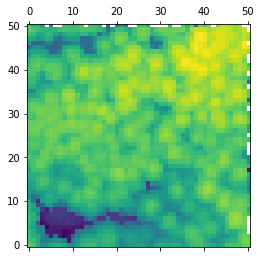

In [33]:
matrix_plot(gridded_df1)

Thanks to the `grid` function, we can easily resize our pixels if we desire something more fine-grained:

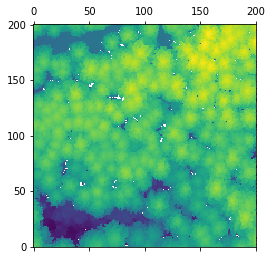

In [35]:
matrix_plot(grid(las1, 0.5))

There is, of course, some fine tuning to do yet. For example, in our first plot the edges seem to have NaN values. Also, our axes should reflect the X Y coordinates in UTM space, but instead refer to the bin ids. I will leave these fixes as an exercise to the reader.